# Speech compression for unit discovery and voice conversion

Ryan Eloff, ryan.peter.eloff@gmail.com, March 2019.

### Preamble

Re-load all modules before executing Python cells, and use the matplotlib 'inline' backend:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import os
import sys
import pickle
import datetime
import functools

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [5]:
sys.path.append(os.path.join("..", "src"))
sys.path.append(os.path.join("..", "embeddings"))

In [6]:
from flags import FLAGS
from utils import data_loader
from utils import batching
from utils import logs
from tf_base.models import layers
from tf_base.models import latents
from tf_base.models import losses
from tf_base import training

### Load and process data

In [7]:
# DATA PARAMETERS
# ---------------
# Input and target features
speech_dir = os.path.join("..", "features")
input_feats="mfcc"  # one of "mfcc" or "fbank"
target_feats="fbank"  # one of "mfcc" or "fbank"
language="english"  # one of "english" or "surprise"
source="fftnet_segments"  # dir containing 'train.npz' and 'test.npz'
load_parallel=False  # load parallel speech features
target_speaker="V001"  # one of "V001" or "V002" or None

# Data pre-processing
d_input_limit = None  # limit dimensionality of input features (e.g. 13 for MFCC without delta & delta-delta)
d_target_limit = None  # limit dimensionality of target features
split_length = 128  # split segments into smaller segments with specified number of frames
split_include_smaller = False  # include segments smaller than the split length

# Model storage
previous_dir = "190314_09h02m50s_747571"  # directory of a previous model run for evaluation or further training (or None for new run)

In [8]:
# Get model directory
model_dir = os.path.join(
    "models",
    "{}-{}".format(input_feats, target_feats),
    language,
    source,
    "target_{}".format("none" if target_speaker is None else target_speaker),
    datetime.datetime.now().strftime("%y%m%d_%Hh%Mm%Ss_%f") if previous_dir is None else previous_dir)

# Create model directory (if it does not exist)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set logger to log to file
logs.set_logger(model_dir, log_fn="console.log")

Logging to file models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/console.log


In [9]:
# Load speech data
input_sets, target_sets, lookup_tables = data_loader.load_speech_features(
    speech_dir=speech_dir, input_feats=input_feats, target_feats=target_feats,
    language=language, source=source, load_parallel=load_parallel,
    target_speaker=target_speaker)

speaker_to_id, id_to_speaker = lookup_tables

Reading npz from file: ../features/mfcc/english/fftnet_segments/train.npz
Example key: S052_1757679286
No. of utterances in npz: 9474
Reading npz from file: ../features/mfcc/english/fftnet_segments/test.npz
Example key: S009_2514890084
No. of utterances in npz: 13529
Reading npz from file: ../features/fbank/english/fftnet_segments/train.npz
Example key: S015_0361841101
No. of utterances in npz: 9474
Reading npz from file: ../features/fbank/english/fftnet_segments/test.npz
Example key: S002_0006942614
No. of utterances in npz: 13529
{'V001', 'S061', 'S038', 'S087', 'S044', 'S057', 'S051', 'S002', 'S053', 'S113', 'S029', 'S035', 'S099', 'S047', 'S088', 'S071', 'S046', 'S121', 'S123', 'S020', 'S011', 'S008', 'S083', 'S119', 'S115', 'S078', 'S013', 'S126', 'S109', 'S023', 'S062', 'S067', 'S058', 'S128', 'S022', 'S007', 'S118', 'S006', 'S125', 'S039', 'S110', 'S132', 'S003', 'S056', 'S037', 'S116', 'S021', 'S042', 'S036', 'S101', 'S048', 'S059', 'S114', 'V002', 'S015', 'S063', 'S086', 'S112

In [10]:
# Limit dimensionality of speech features
if d_input_limit is not None:
    for speech_dict in input_sets:
        data_loader.limit_dimensionality(speech_dict, d_input_limit)

if d_input_limit is not None:
    for speech_dict in target_sets:
        data_loader.limit_dimensionality(speech_dict, d_target_limit)

In [11]:
# Split speech segments
input_split_sets = tuple()
for speech_dict in input_sets:
    split_speech_dict = data_loader.sequential_split_segments(
        speech_dict, split_length, include_smaller=split_include_smaller, modify_inplace=False)
    input_split_sets += (split_speech_dict, )

target_split_sets = tuple()
for speech_dict in target_sets:
    split_speech_dict = data_loader.sequential_split_segments(
        speech_dict, split_length, include_smaller=split_include_smaller, modify_inplace=False)
    target_split_sets += (split_speech_dict, )
    
# get speaker ids for split input and target sets
get_speaker_ids = np.vectorize(
    lambda speaker: speaker_to_id[speaker], otypes=[FLAGS.np_int_dtype])
for input_set in input_split_sets:
    input_set["speaker_ids"] = get_speaker_ids(input_set["speakers"])
for target_set in target_split_sets:
    target_set["speaker_ids"] = get_speaker_ids(target_set["speakers"])

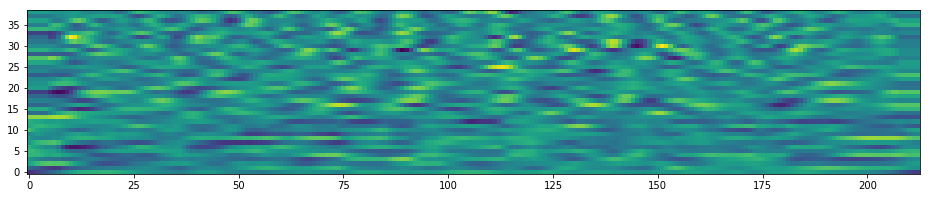

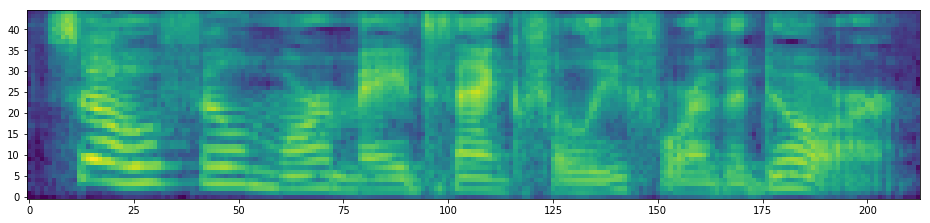

In [12]:
# Example features from train input and target sets
plt.figure(figsize=(16, 8))
plt.imshow(input_sets[0]["x"][-1].T, origin="bottom")

plt.figure(figsize=(16, 8))
plt.imshow(target_sets[0]["x"][-1].T, origin="bottom")

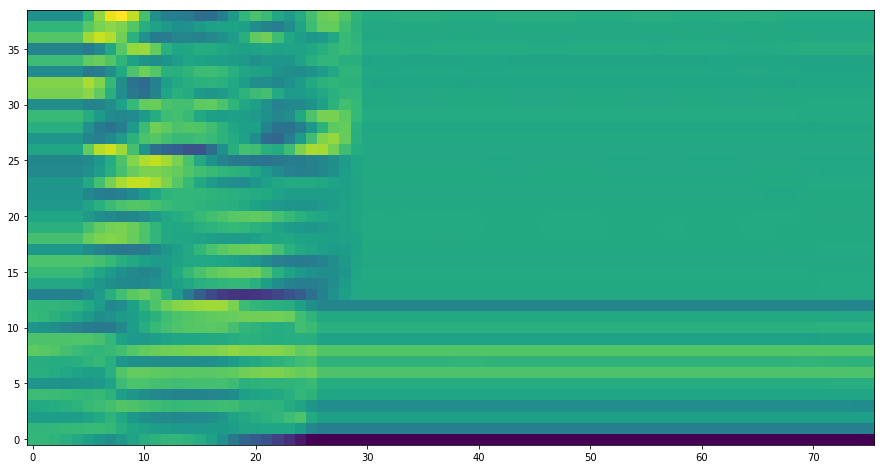

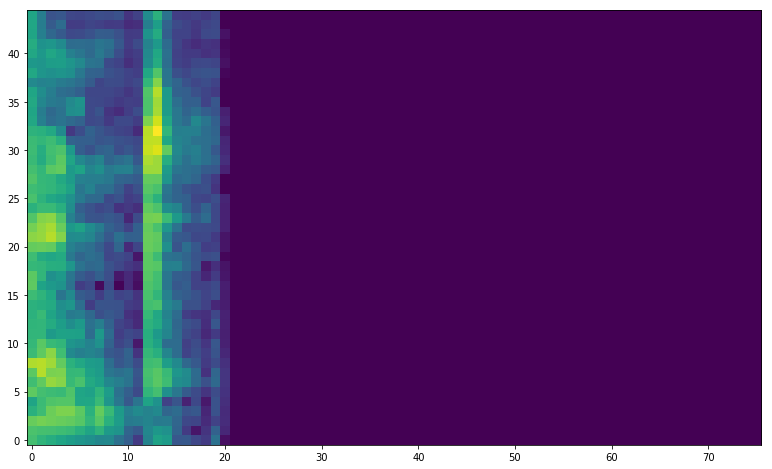

In [13]:
# Example features from test input and target sets
plt.figure(figsize=(16, 8))
plt.imshow(input_sets[1]["x"][-1].T, origin="bottom")

plt.figure(figsize=(16, 8))
plt.imshow(target_sets[1]["x"][-1].T, origin="bottom")

In [14]:
if load_parallel:
    # Example features from parallel input and target sets
    plt.figure(figsize=(16, 8))
    plt.imshow(input_sets[2]["x"][-1].T, origin="bottom")

    plt.figure(figsize=(16, 8))
    plt.imshow(target_sets[2]["x"][-1].T, origin="bottom")

Feature data mean: 0.001
Feature data max value: 9.629
Feature data min value: -9.597
Longest segment: 4789 frames
Mean plus 2 std deviations (~95%): 2069 frames
Outliers above mean plus 2 std deviations: 63 (0.665 %)


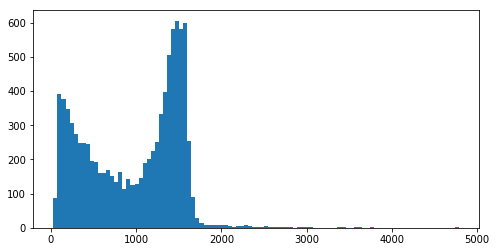

In [15]:
# Train (input) speech data statistics
data_loader.display_stats(input_sets[0])

Feature data mean: -0.011
Feature data max value: 7.407
Feature data min value: -7.547
Longest segment: 1694 frames
Mean plus 2 std deviations (~95%): 250 frames
Outliers above mean plus 2 std deviations: 250 (1.848 %)


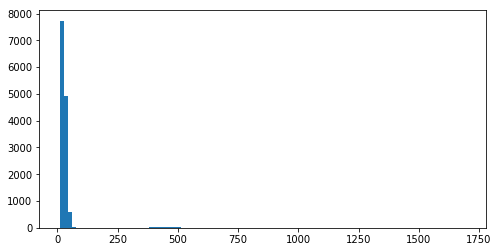

In [16]:
# Test (input) speech data statistics
data_loader.display_stats(input_sets[1])

In [17]:
if load_parallel:
    # Parallel input speech data statistics
    data_loader.display_stats(input_sets[2])

In [18]:
if load_parallel:
    # Parallel target speech data statistics
    data_loader.display_stats(target_sets[2])

### Build compression model

In [19]:
# MODEL PARAMETERS
# ----------------
# Model input
d_encoder_input_feats = np.shape(input_sets[0]["x"][0])[-1]  # input speech feature dimensionality
d_decoder_target_feats = np.shape(target_sets[0]["x"][0])[-1]  # target speech feature dimensionality

# Model architecture
padding = "same"  # padding in convolutional layers
activation = "relu"  # activation function after convolution and dense layers
data_format = "channels_last"  # feature data format 
base_depth = 128  # base depth of network (used in multiples of 2, e.g. 2*base_depth)
inital_kernel = None  # 8  # initial 1D kernel for extracting speech features (e.g. 8 or 9)
conv_kernel = 3  # 1D kernel used in convolutional layers
downsample_kernel = 4  # 1D kernel used in downsample/upsample convolution layers
n_downsample = 3  # number of downsample layers, reducing temporal dimension by factor 2**n_downsample
n_residual = 8  # number of residual feature-extraction (and decoder reconstruction) layers
initial_depth = base_depth
downsample_depth = base_depth * 2
residual_depth = base_depth * 4
upsample_first = True
add_final_residual = True
n_stacked_rnn = None
rnn_units = base_depth * 2
rnn_cell = "lstm"
bidirectional = True

# Regularisation
drop_rate = 0.0  # probability of dropping units (temporal) or activation maps (spatial)
drop_timesteps = 0.0
drop_features = 0.0
use_batch_norm = True  # apply batch norm to pre-activation layers 
weight_decay = 1e-5  # weight decay for L2 regularisation

# Speaker conditioning
use_speaker_condition = True  # condition decoder on target speaker
embed_speaker_id = True  # learn speaker embeddings, otherwise use one-hot encoding
n_speakers = max(speaker_to_id.values()) + 1  # number of speakers according to speaker-id lookup table (not all speakers are used during training, and some speakers are unseen at test time)
d_speaker_embedding = 2 * base_depth  # speaker embedding dimensionality (only if learning speaker embeddings)

# Latent variable bottleneck
bottleneck = "VQ-VAE"  # one of "CatVAE", "VQ-VAE"
n_symbols = 512  # number of discrete symbols, larger values increase capacity in the information bottleneck

vq_vae_kwargs = {
    "k_discrete": n_symbols,
    "z_units": 2 * base_depth
}

cat_vae_kwargs = {
    "n_distributions": 1,
    "k_categories": n_symbols // 1,  # (n_symbols = n_distributions*k_categories)
    "straight_through": True   # use ST Gumbel Estimator
}

if bottleneck == "VQ-VAE":
    latent_size = vq_vae_kwargs["z_units"]
elif bottleneck == "CatVAE":
    latent_size = cat_vae_kwargs["n_distributions"] * cat_vae_kwargs["k_categories"]
else:
    raise ValueError("Bottleneck not in list of allowed values: {}", bottleneck)

# d_decoder_input_feats = latent_size
# if use_speaker_condition:
#     d_decoder_input_feats += d_speaker_embedding

# Training
seed = 42
n_epochs = 200
learning_rate = 1e-3

# Batching
batch_size = 200
n_buckets = 3

# CatVAE temperature schedule
tau_init = 1.  # CatVAE temperature schedule start value
tau_min = 0.1  # CatVAE temperature schedule minimum value
# tau_list = np.linspace(tau_init, tau_min, n_epochs)  # CatVAE temperature schedule

# Loss function 
mask_loss = True  # mask sequence padding in reconstruction loss
recon_loss = "mse"
commit_beta = 25.0
recon_sigma_sq = 1e-6

# Model storage
def get_model_file(
        n_stacked_rnn, bottleneck, recon_sigma_sq,
        commit_beta, n_downsample, target_speaker,
        final_epoch=False):
    return os.path.join(
        model_dir, "{}conv_deconv_{}_sigma_sq_{}_beta_{}_compression_{}_speaker_{}{}.ckpt".format(
            "rnn_" if n_stacked_rnn is not None else "",
            bottleneck,
            recon_sigma_sq,
            commit_beta,
            2**n_downsample,
            "none" if target_speaker is None else target_speaker,
            "_final_epoch" if final_epoch else ""))

model_file = get_model_file(
    n_stacked_rnn, bottleneck, recon_sigma_sq,
    commit_beta, n_downsample, target_speaker,
    final_epoch=False)
model_file_final = get_model_file(
    n_stacked_rnn, bottleneck, recon_sigma_sq,
    commit_beta, n_downsample, target_speaker,
    final_epoch=True)

In [20]:
# MODEL LAYERS
# ------------

# Regularisation layers
dropout1D = functools.partial(tf.keras.layers.Dropout, rate=drop_rate)  # temporal dropout
dropout2D = functools.partial(tf.keras.layers.SpatialDropout2D, rate=drop_rate)  # spatial dropout
batch_norm = tf.keras.layers.BatchNormalization

# Fully-connected layers
dense = tf.keras.layers.Dense

# Convolution layers
conv1D = functools.partial(  # 1D convolution (temporal)
    tf.keras.layers.Conv1D, activation="relu",
    padding=padding, data_format=data_format)

conv2D = functools.partial(  # 2D convolution (spatial)
    tf.keras.layers.Conv2D, activation="relu",
    padding=padding, data_format=data_format)

deconv2D = functools.partial(  # 2D transpose convolution ("deconvolution")
    layers.WrapConv2D, conv2D=tf.keras.layers.Conv2DTranspose,
    batch_norm=use_batch_norm, activation="relu",
    downsample=None, dropout=dropout2D,
    padding=padding, data_format=data_format)

residual_conv2D = functools.partial(  # 2D residual convolution
    layers.ResidualConv2D, project_shortcut=False,
    conv2b_kernel=(1, 1), strides=(1, 1),
    activation="relu", batch_norm=use_batch_norm,
    data_format=data_format, padding=padding)

residual_dense = functools.partial(  # residual fully-connected
    layers.ResidualDense, project_shortcut=False,
    activation="relu", batch_norm=use_batch_norm)

# RNN layers
lstm = functools.partial(  # long-short term memory (seq2seq)
    tf.keras.layers.LSTM, return_sequences=True,
    recurrent_dropout=drop_rate)

gru = functools.partial(  # gated recurrent unit (seq2seq)
    tf.keras.layers.GRU, return_sequences=True,
    recurrent_dropout=drop_rate)

In [21]:
tf.reset_default_graph()
tf.set_random_seed(seed)
np.random.seed(seed)

# BUILD MODEL INPUT TENSORS
# -------------------------
encoder_input = tf.keras.layers.Input(
    shape=[None, d_encoder_input_feats], batch_size=None, dtype=FLAGS.tf_float_dtype)
decoder_input = tf.keras.layers.Input(
    shape=[None, latent_size], batch_size=None, dtype=FLAGS.tf_float_dtype)
decoder_target = tf.keras.layers.Input(
    shape=[None, d_decoder_target_feats], batch_size=None, dtype=FLAGS.tf_float_dtype)
input_lengths = tf.keras.layers.Input(  # dummy placeholder, never used
    shape=[], batch_size=None, dtype=FLAGS.tf_int_dtype)
target_lengths = tf.keras.layers.Input(
    shape=[], batch_size=None, dtype=FLAGS.tf_int_dtype)
speaker_id = tf.keras.layers.Input(
    shape=[], batch_size=None, dtype=FLAGS.tf_int_dtype)
tau = tf.keras.layers.Input(  # CatVAE temperature
    shape=[], batch_size=None, dtype=FLAGS.tf_float_dtype)

# BUILD SPEAKER CONDITION TENSOR
# ------------------------------
if use_speaker_condition:
    if embed_speaker_id:  # use embedded speaker condition
        speaker_embeddings = tf.get_variable(
            "speaker_embeds", [n_speakers, d_speaker_embedding], dtype=FLAGS.tf_float_dtype)
        speaker_condition = tf.keras.layers.Lambda(
            lambda inputs: tf.nn.embedding_lookup(speaker_embeddings, inputs))
    else:  # use one-hot speaker condition
        speaker_condition = tf.keras.layers.Lambda(
            lambda inputs: tf.one_hot(inputs, n_speakers))

# UTILLITY LAYERS
# ---------------
max_length = tf.keras.layers.Lambda(lambda inputs: tf.shape(inputs)[1])
        
# BUILD COMPRESSION MODEL (ENCODER)
# ---------------------------------
def build_encoder(encoder_input):
    # Pad encoder input for valid compression
    def pad_input(encoder_input, max_length):
        pad_length = 2**n_downsample - tf.floormod(max_length, 2**n_downsample)
        pad_length = tf.cond(  # check if max_length % 2**n_downsample == 0
            tf.equal(pad_length, 2**n_downsample),
            true_fn=lambda: tf.constant(0),  # no padding
            false_fn=lambda: pad_length)  # pad by padding  
        encoder_input_padded = tf.pad(encoder_input, [[0, 0], [0, pad_length], [0, 0]])
        return encoder_input_padded
    pad_layer = tf.keras.layers.Lambda(lambda inputs: pad_input(*inputs))  # wrap padding function in keras layer

    # Start of speech encoding
    encoder_output = pad_layer([encoder_input, max_length(encoder_input)])

    # Reshape to spatial input
    spatial_reshape = tf.keras.layers.Reshape((-1, 1, d_encoder_input_feats)) # reshape features as spatial channels
    encoder_output = spatial_reshape(encoder_output)

    # Initial pre-processing convolution
    if inital_kernel is not None:
        preprocess_conv = conv2D(filters=initial_depth, kernel_size=(inital_kernel, 1))
        encoder_output = preprocess_conv(encoder_output)

    # Downsampling strided convolutions
    for i in range(n_downsample):
        downsample = conv2D(filters=downsample_depth, kernel_size=(downsample_kernel, 1), strides=(2, 1))
        encoder_output = downsample(encoder_output)

    # Feature extraction residual convolutions
    for i in range(n_residual):
        if i == 0:
            project_shortcut = True
        else:
            project_shortcut = False
        residual_conv = residual_conv2D(
            conv2a_depth=residual_depth, conv2a_kernel=(conv_kernel, 1), project_shortcut=project_shortcut)
        encoder_output = residual_conv(encoder_output)

    # Reshape to temporal frames
    pre_rnn_depth = encoder_output.get_shape().as_list()[-1]
    temporal_reshape = tf.keras.layers.Reshape((-1, pre_rnn_depth))
    encoder_output = temporal_reshape(encoder_output)

    # RNN temporal feature extraction
    if n_stacked_rnn is not None:
        if rnn_cell == "gru":
            rnn_func = gru
        elif rnn_cell == "lstm":
            rnn_func = lstm
        for i in range(n_stacked_rnn):
            rnn_layer = rnn_func(rnn_units)
            if bidirectional:
                rnn_layer = tf.keras.layers.Bidirectional(rnn_layer)
            encoder_output = rnn_layer(encoder_output)

    # Reshape to stack frames across the batch
    pre_latent_frames = max_length(encoder_output)
    pre_latent_depth = encoder_output.get_shape().as_list()[-1]
    stack_reshape = tf.keras.layers.Lambda(  # keras does not allow stacking along batch dimension
        lambda inputs: tf.reshape(inputs, (-1, pre_latent_depth)))
    encoder_output = stack_reshape(encoder_output)    

    # Latent variable bottleneck
    if bottleneck == "VQ-VAE":
        latent = latents.VQVAELatent(z_units=vq_vae_kwargs["z_units"], k_discrete=vq_vae_kwargs["k_discrete"])
        latent_outputs = latent(encoder_output)
        z_straight_through, z_quantised, z_continuous, z_one_hot = latent_outputs
        encoder_output = z_straight_through
        perplexity = latent.perplexity
        embed_codebook = latent.embed_codebook
        bottleneck_output = z_quantised  # don't use ST estimation for ABX, since ST is not hard discrete
        auxillary_outputs = {
            "z_continuous": z_continuous,
            "z_one_hot": z_one_hot}
        tracking_outputs = {
            "perplexity": perplexity,
            "embed_codebook": embed_codebook}
    elif bottleneck == "CatVAE":
        latent = latents.CatVAELatent(
            n_distributions=cat_vae_kwargs["n_distributions"], k_categories=cat_vae_kwargs["k_categories"],
            straight_through=cat_vae_kwargs["straight_through"], tau=tau)
        latent_outputs = latent(encoder_output)
        z_cat, softmax_logits, log_logits_categorical = latent_outputs
        encoder_output = z_cat
        auxillary_outputs = [softmax_logits, log_logits_categorical]
    else:
        raise ValueError("Bottleneck not in list of allowed values: {}", bottleneck)

    # Reshape latent outputs to temporal frames
    temporal_reshape = tf.keras.layers.Lambda(  # all tf.Tensors should be wrapped ...
        lambda inputs: tf.reshape(
            inputs[0], shape=(-1, inputs[1], inputs[0].get_shape().as_list()[-1])))
    encoder_output = temporal_reshape([encoder_output, pre_latent_frames])
    bottleneck_output = temporal_reshape([bottleneck_output, pre_latent_frames])
    for key, auxillary_output in auxillary_outputs.items():
        auxillary_outputs[key] = temporal_reshape([auxillary_output, pre_latent_frames])
    return encoder_output, bottleneck_output, auxillary_outputs, tracking_outputs

# BUILD RECONSTRUCTION MODEL (DECODER)
# ------------------------------------
def build_decoder(decoder_input, speaker_id, target_lengths=None, encoder_input=None):
    # Concatenate speaker condition
    decoder_output = decoder_input
    if use_speaker_condition:
        temporal_tile = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(tf.expand_dims(  # tile speaker condition tensor 
                tf.tile(inputs[0], [1, tf.shape(inputs[1])[1]]), axis=-2),
                shape=(-1, tf.shape(inputs[1])[1], inputs[0].get_shape().as_list()[-1])))
        decoder_output = tf.keras.layers.concatenate([  # concatenate tiled speaker condition with input frames
            temporal_tile([speaker_condition(speaker_id), decoder_output]), decoder_output])
    
    # Decoder regularisation
    if drop_timesteps != 0.0:
        dropout_time = tf.keras.layers.Lambda(
            lambda inputs: dropout1D(
                rate=drop_timesteps,
                noise_shape=[tf.shape(inputs)[0], tf.shape(inputs)[1], 1])(inputs))
        decoder_output = dropout_time(decoder_output)
    if drop_features != 0.0:
        dropout_feats = tf.keras.layers.Lambda(
            lambda inputs: dropout1D(
                rate=drop_features,
                noise_shape=[tf.shape(inputs)[0], 1, tf.shape(inputs)[2]])(inputs))
        decoder_output = dropout_feats(decoder_output)
    
    # RNN temporal feature reconstruction
    if n_stacked_rnn is not None:
        if rnn_cell == "gru":
            rnn_func = gru
        elif rnn_cell == "lstm":
            rnn_func = lstm
        for i in range(n_stacked_rnn):
            rnn_layer = rnn_func(rnn_units)
            if bidirectional:
                rnn_layer = tf.keras.layers.Bidirectional(rnn_layer)
            decoder_output = rnn_layer(decoder_output)
    
    # Reshape to spatial input
    spatial_reshape = tf.keras.layers.Reshape((-1, 1, decoder_output.get_shape().as_list()[-1])) # reshape features as spatial channels
    decoder_output = spatial_reshape(decoder_output)
    
    # Upsample before feature reconstruction
    if upsample_first:
        # Upsampling strided transpose convolutions ("deconvolution")
        for i in range(n_downsample):
            upsample = deconv2D(filters=downsample_depth, kernel_size=(downsample_kernel, 1), strides=(2, 1))
            upsample_output = upsample(decoder_output)  # store upsample output for later
            decoder_output = upsample_output
    
    # Feature reconstruction residual convolutions
    for i in range(n_residual):
        if i == 0:
            project_shortcut = True
        residual_conv = residual_conv2D(
            conv2a_depth=residual_depth, conv2a_kernel=(conv_kernel, 1), project_shortcut=project_shortcut)
        decoder_output = residual_conv(decoder_output)
    
    # Upsample after feature reconstruction
    if not upsample_first:
        # Upsampling strided transpose convolutions ("deconvolution")
        for i in range(n_downsample):
            upsample = deconv2D(filters=downsample_depth, kernel_size=(downsample_kernel, 1), strides=(2, 1))
            decoder_output = upsample(decoder_output)
    
    # Linear target feature reconstruction convolution
    output_conv = conv2D(filters=d_decoder_target_feats, kernel_size=(1, 1), activation=None)
    decoder_output = output_conv(decoder_output)
    
    # 
    if upsample_first and add_final_residual:
        project_conv = conv2D(filters=d_decoder_target_feats, kernel_size=(1, 1), activation=None)
        projected_residual = project_conv(upsample_output)
        add_concat = tf.keras.layers.Add()
        decoder_output = add_concat([decoder_output, projected_residual])
    
    # Reshape to reconstructed temporal frames
    temporal_reshape = tf.keras.layers.Reshape((-1, d_decoder_target_feats))
    decoder_output = temporal_reshape(decoder_output)
    
    # Mask zero-padding and slice to batch max length (which may have been padded)
    if target_lengths is not None:

        target_slice_mask = tf.keras.layers.Lambda(
            lambda inputs: tf.multiply(
                inputs[0],
                tf.expand_dims(
                    tf.sequence_mask(
                        inputs[1], inputs[2], dtype=FLAGS.tf_float_dtype),
                    axis=-1)
            )[:, :inputs[3], :])
        decoder_output = target_slice_mask([
            decoder_output, target_lengths, max_length(decoder_output), max_length(encoder_input)])
    
    return decoder_output

# BUILD INFERENCE AND TRAINING MODELS
# -----------------------------------
compression_output, bottleneck_output, auxillary_outputs, tracking_outputs = build_encoder(encoder_input)
reconstruction_output = build_decoder(decoder_input, speaker_id)  # reconstruction inference does not know target lengths
model_output = build_decoder(compression_output, speaker_id, target_lengths, encoder_input)

compression_model = tf.keras.models.Model(encoder_input, compression_output)
reconstruction_model = tf.keras.models.Model([decoder_input, speaker_id, target_lengths], reconstruction_output)    
model = tf.keras.models.Model([encoder_input, speaker_id, target_lengths], model_output)

In [22]:
compression_output

<tf.Tensor 'lambda_5/Reshape:0' shape=(?, ?, 256) dtype=float32>

In [23]:
compression_config = compression_model.get_config()
reconstruction_config = reconstruction_model.get_config()
model_config = model.get_config()

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 39)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               ()                   0           input_1[0][0]                    
                                                                 reshape_1[0][0]                  
                                                                 reshape_5[0][0]                  
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 39)     0           input_1[0][0]                    
          

In [25]:
compression_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 39)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               ()                   0           input_1[0][0]                    
                                                                 reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 39)     0           input_1[0][0]                    
                                                                 lambda_1[0][0]                   
__________________________________________________________________________________________________
reshape (R

In [26]:
reconstruction_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None,)              0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256)          0           input_6[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 256)    0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, None, 256)    0           lambda[0][0]                     
                                                                 input_2[0][0]                    
__________

In [27]:
# BUILD LOSS AND OPTIMISER
# ------------------------
# Reconstruction loss term
if recon_loss == "mse":
    reconstruction_loss = losses.mse_reconstruction_loss(
        decoder_target, model_output, sequence_lengths=target_lengths if mask_loss else None)
    scaled_recon_loss = 1./(2*recon_sigma_sq) * reconstruction_loss
else:
    raise ValueError("Reconstruction loss not in list of allowed values: {}", recon_loss)

# Bottleneck loss terms
if bottleneck == "VQ-VAE":
    vq_vae_loss, commitment_loss = losses.vq_vae_loss(
        auxillary_outputs["z_continuous"], bottleneck_output, beta=commit_beta)
    loss = scaled_recon_loss + vq_vae_loss
    loss_terms = [
        loss, commitment_loss, scaled_recon_loss,
        tracking_outputs["perplexity"], reconstruction_loss]
elif bottleneck == "CatVAE":
    pass
else:
    raise ValueError("Bottleneck not in list of allowed values: {}", bottleneck)

# Optimiser
update_ops = model.updates
with tf.control_dependencies(update_ops):
    # run update ops before optimiser (required to update batch norm mean and variance)
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [28]:
# BATCH ITERATORS
# ---------------
train_iterator = batching.BucketBatcher(
    input_split_sets[0]["x"], target_split_sets[0]["x"], target_split_sets[0]["speaker_ids"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True, return_lengths=True)

val_iterator = batching.BucketBatcher(
    input_split_sets[1]["x"], target_split_sets[1]["x"], speaker_to_id["V001"],
    batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=False, return_lengths=True)

In [ ]:
# TRAIN MODEL
# -----------
train_feed = {
    tf.keras.backend.learning_phase(): 1
}

validation_feed = {
    tf.keras.backend.learning_phase(): 0
}

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    # Training params
    n_epochs, optimiser, loss_terms, train_iterator,  
    [encoder_input, decoder_target, speaker_id, target_lengths],
    # Validation params
    loss_terms, val_iterator, save_best_val_model_fn=model_file,
    # Additional params
    additional_train_feed=train_feed, additional_validation_feed=validation_feed,
    config=config, save_model_fn=model_file_final,
    # Continue training previous model
    load_model_fn=model_file, epoch_offset=54)

2019-03-14 11:52:05.017046
INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Epoch 54:
93.739 sec, train loss: [2.6601367e+03 2.7778442e+01 1.9378978e+03 1.1443232e+02 3.8757951e-03], val loss: [8.0193062e+03 3.6931721e+01 7.0590806e+03 9.2113167e+01 1.4118162e-02] *
Epoch 55:
93.654 sec, train loss: [2.6392649e+03 2.7434050e+01 1.9259792e+03 1.1542210e+02 3.8519586e-03], val loss: [8.2051016e+03 4.0973095e+01 7.1398008e+03 9.0792114e+01 1.4279601e-02]
Epoch 56:
92.099 sec, train loss: [2.6195151e+03 2.7129007e+01 1.9141615e+03 1.1650696e+02 3.8283214e-03], val loss: [7.3295059e+03 4.4172291e+01 6.1810269e+03 9.0126213e+01 1.2362053e-02] *
Epoch 57:
91.624 sec, train loss: [2.6123281e+03 2.6940132e+01 1.9118857e+03 1.1725204e+02 3.8237730e-03], val loss: [7.8322192e+03 4.3256516e+01 6.7075508e+03 9.2251915e+01 1.3415101e-02]
Epoch 58:


In [ ]:
pickle_file = os.path.join(
    model_dir, "train_record_{}.pickle".format(datetime.datetime.now().strftime("%y%m%d_%Hh%Mm%Ss_%f")))
with open(pickle_file, "wb") as file:
     pickle.dump(record_dict, file)

In [29]:
def embed_and_save(
        input_set, model_file, x_input, x_lengths, latent_encoding, decoder_output,
        aux_encoding_dict=None, speaker_id=None, output_dir="embedded", batch_size=1, shuffle=False,
        config=None, additional_feed=None, target_speaker_id=None):
    # Embedding dicts
    encoded_dict = {}
    decoded_dict = {}
    if aux_encoding_dict is not None:
        aux_dicts = {aux_key: {} for aux_key, _ in aux_encoding_dict.items()}
    # Input iterator
    embed_iterator = batching.BucketBatcher(
        input_set["x"], input_set["keys"],
        batch_size=batch_size, n_buckets=50,  # many buckets to increase speed
        shuffle_first_epoch=shuffle, shuffle_every_epoch=False,
        small_final_batch=True, return_lengths=True)
    # Embed input features
    saver = tf.train.Saver()
    with tf.Session(config=config) as session:
        saver.restore(session, model_file)
        for batch, batch_lengths in tqdm_notebook(embed_iterator):
            x_input_np = batch[0]
            batch_keys = batch[1]
            x_lengths_np = batch_lengths[0]
            feed_dict = {x_input: x_input_np, x_lengths: x_lengths_np}
            if additional_feed is not None:
                feed_dict.update(additional_feed)
            if target_speaker_id is not None:
                feed_dict[speaker_id] = np.array([target_speaker_id]*np.shape(x_input_np)[0])
            z_encoding_np = session.run(latent_encoding,
                                        feed_dict=feed_dict)
            y_decoded_np = session.run(decoder_output,
                                       feed_dict=feed_dict)
            z_dim_feats = np.shape(z_encoding_np)[-1]
            y_dim_feats = np.shape(y_decoded_np)[-1]
            for z_enc, y_dec, length, key in zip(z_encoding_np, y_decoded_np,
                                                 x_lengths_np, batch_keys):
                z_enc_unpad = np.zeros((length, z_dim_feats), dtype=FLAGS.np_float_dtype)
                y_enc_unpad = np.zeros((length, y_dim_feats), dtype=FLAGS.np_float_dtype)
                z_enc_unpad = z_enc[:length, :]
                y_enc_unpad = y_dec[:length, :]
                encoded_dict[key] = z_enc_unpad
                decoded_dict[key] = y_enc_unpad
            if aux_encoding_dict is not None:  # eval and save auxillary encodings
                z_aux_dicts_np = {}
                for aux_key, z_auxiliary in aux_encoding_dict.items():
                    z_auxiliary_np = session.run(z_auxiliary,
                                                 feed_dict=feed_dict)
                    z_aux_dicts_np[aux_key] = z_auxiliary_np
                    z_aux_dim_feats = np.shape(z_auxiliary_np)[-1]
                    for z_aux_enc, length, key in zip(z_auxiliary_np, x_lengths_np, batch_keys):                            
                        z_aux_unpad = np.zeros((length, z_aux_dim_feats), dtype=FLAGS.np_float_dtype)
                        z_aux_unpad = z_aux_enc[:length, :]
                        aux_dicts[aux_key][key] = z_aux_unpad
    # Create output directory and save embeddings
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    np.savez_compressed(os.path.join(output_dir, "output_encoded.npz"), **encoded_dict)
    np.savez_compressed(os.path.join(output_dir, "output_decoded.npz"), **decoded_dict)
    # Display example embeddings
    ex_key = list(encoded_dict.keys())[-1]
    # Input example
    fig = plt.figure(figsize=(100,6))
    plt.imshow(input_set["x"][np.where(input_set["keys"] == ex_key)[0][0]].T, origin="bottom")
    plt.title("Input sequence")
    fig.savefig(os.path.join(output_dir, "input_example.pdf"), bbox_inches='tight')

    fig = plt.figure(figsize=(100,6))
    plt.imshow(encoded_dict[ex_key].T, origin="bottom")
    plt.title("Encoded sequence")
    fig.savefig(os.path.join(output_dir, "encoded_example.pdf"), bbox_inches='tight')

    fig = plt.figure(figsize=(100,6))
    plt.imshow(decoded_dict[ex_key].T, origin="bottom")
    plt.title("Decoded sequence")
    fig.savefig(os.path.join(output_dir, "decoded_example.pdf"), bbox_inches='tight')
    
    del encoded_dict, decoded_dict
    
    if aux_encoding_dict is not None:
        for dict_key, aux_dict in aux_dicts.items():
            np.savez_compressed(os.path.join(output_dir, "output_auxiliary_{}.npz".format(dict_key)), **aux_dict)

            fig = plt.figure(figsize=(100,6))
            plt.imshow(aux_dict[ex_key].T, origin="bottom")
            plt.title("Auxiliary encoded sequence: {}".format(dict_key))
            fig.savefig(os.path.join(output_dir, "auxiliary_{}_example.pdf".format(dict_key)), bbox_inches='tight')

        return x_input_np, z_encoding_np, y_decoded_np, x_lengths_np, z_aux_dicts_np  # example batch
    else:
        return x_input_np, z_encoding_np, y_decoded_np, x_lengths_np  # example batch

INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt



INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


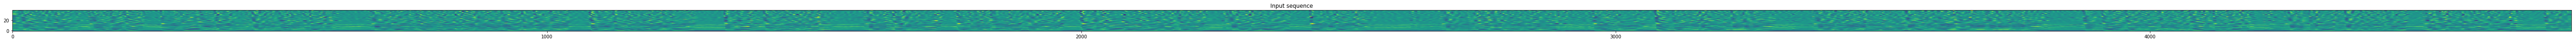

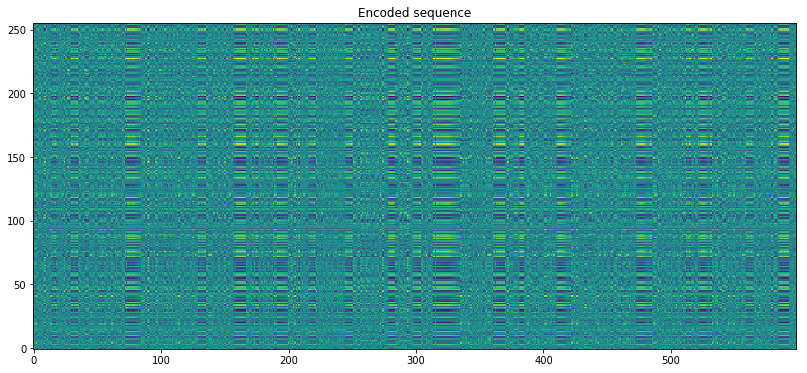

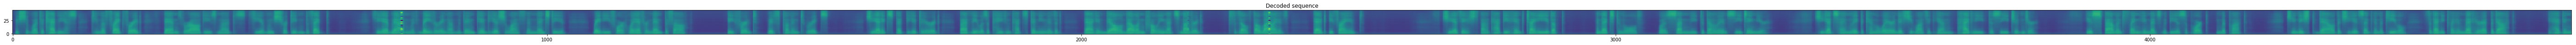

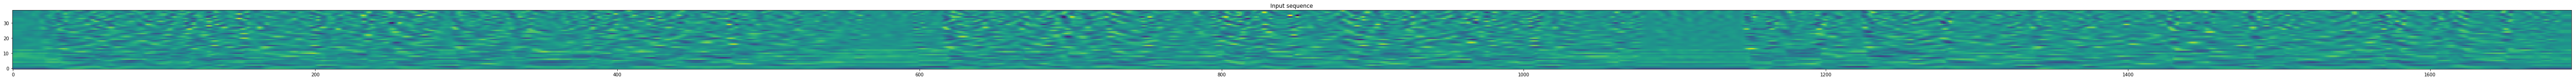

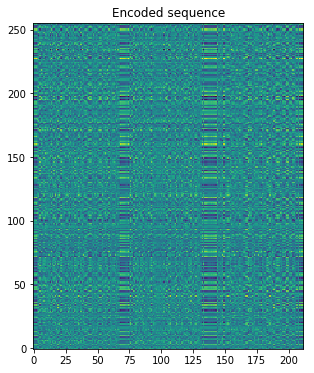

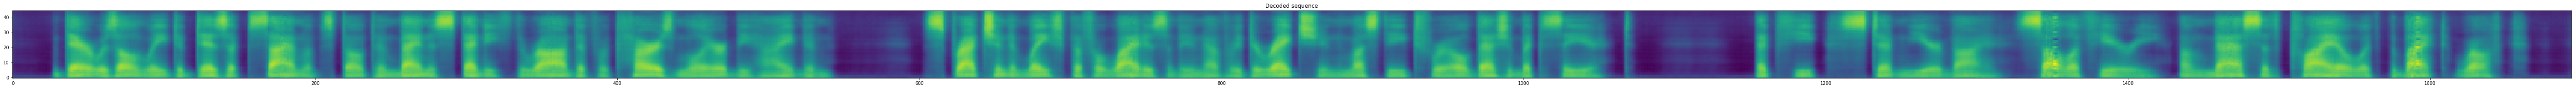

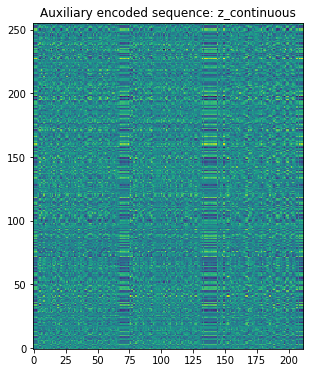

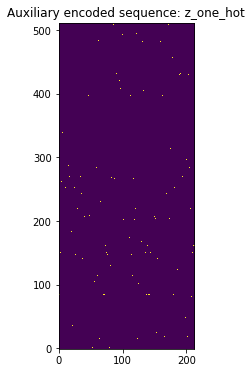

In [30]:
# COMPRESS AND RECONSTRUCT DATA WITH TRAINED MODEL
# ------------------------------------------------
test_feed = {
    tf.keras.backend.learning_phase(): 0  #, tau: [tau_min]
}

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

embed_final_epoch = False
embed_speaker = "V001"

target_speaker_id = speaker_to_id[embed_speaker]  #  "V001" or "V002" for target speakers
embed_dir = "speaker_{}{}".format(
    "none" if embed_speaker is None else embed_speaker,
    "_final_epoch" if embed_final_epoch else "")

embed_and_save(
    input_sets[0], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=None,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "train", embed_dir),
    batch_size=5, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

ex_batch = embed_and_save(
    input_sets[1], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=auxillary_outputs,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "test", embed_dir),
    batch_size=10, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


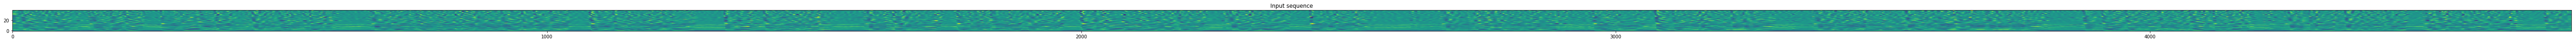

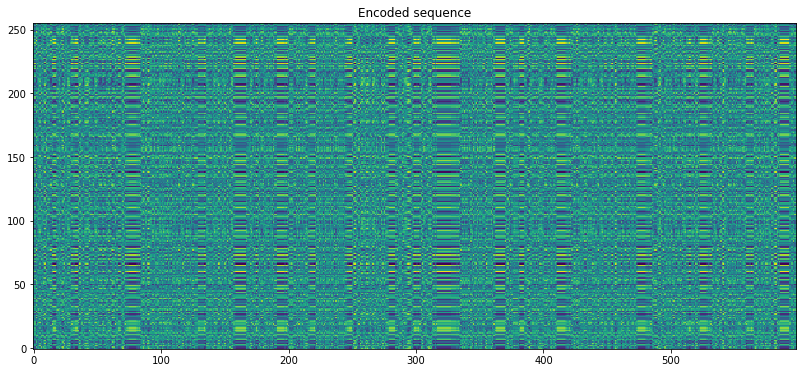

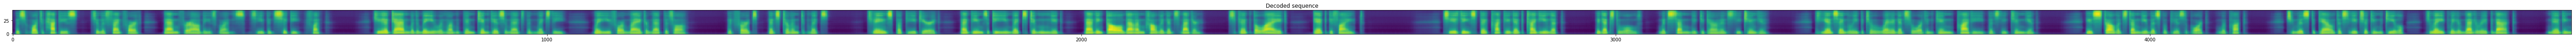

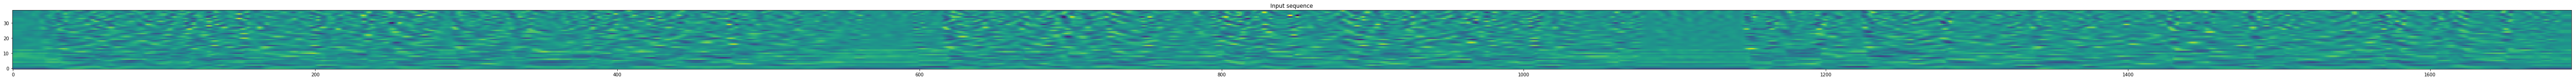

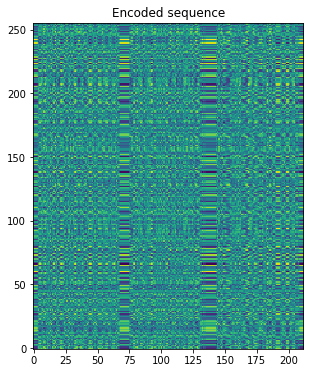

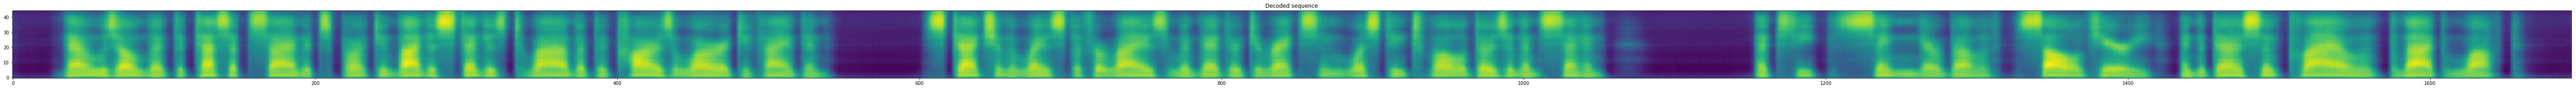

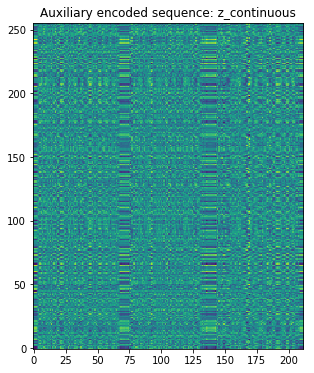

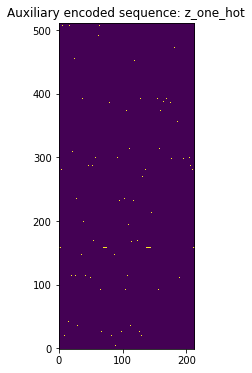

In [90]:
# COMPRESS AND RECONSTRUCT DATA WITH TRAINED MODEL
# ------------------------------------------------
test_feed = {
    tf.keras.backend.learning_phase(): 0  #, tau: [tau_min]
}

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

embed_final_epoch = True
embed_speaker = "V001"

target_speaker_id = speaker_to_id[embed_speaker]  #  "V001" or "V002" for target speakers
embed_dir = "speaker_{}{}".format(
    "none" if embed_speaker is None else embed_speaker,
    "_final_epoch" if embed_final_epoch else "")

embed_and_save(
    input_sets[0], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=None,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "train", embed_dir),
    batch_size=5, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

ex_batch = embed_and_save(
    input_sets[1], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=auxillary_outputs,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "test", embed_dir),
    batch_size=10, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt



INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_09h02m50s_747571/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


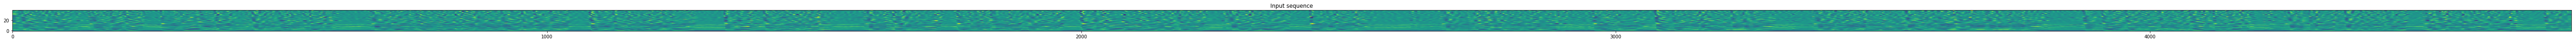

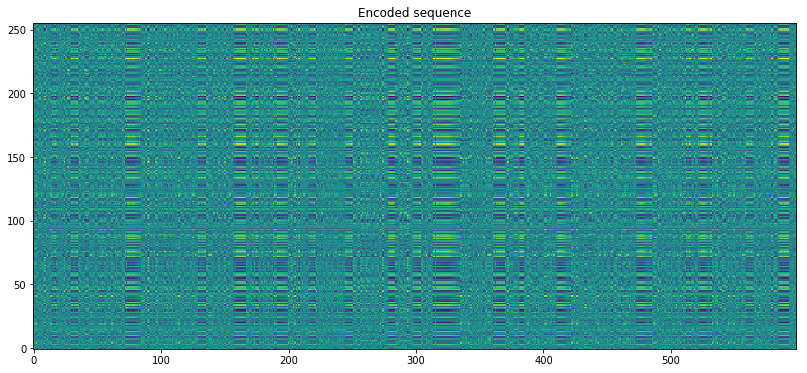

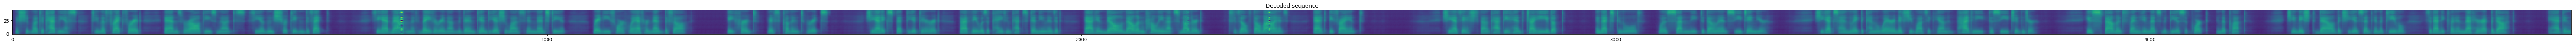

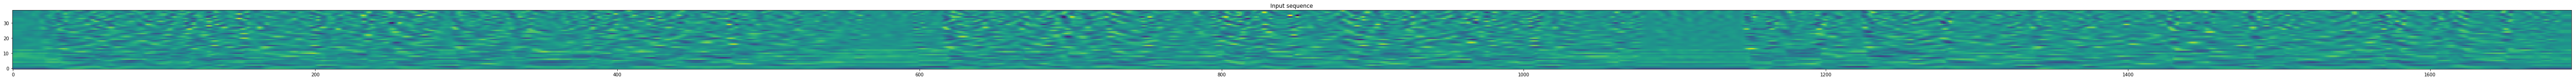

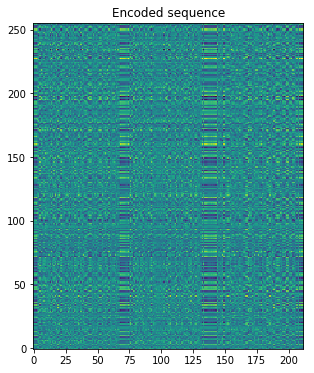

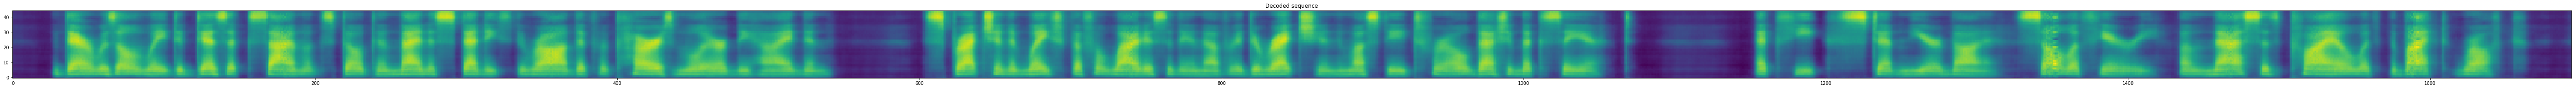

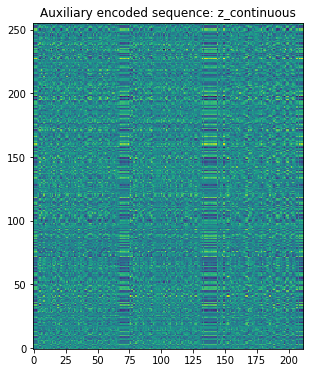

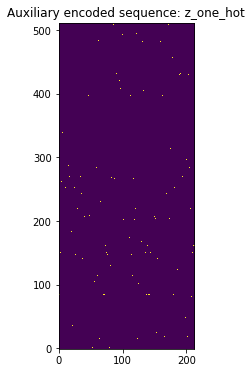

In [31]:
# COMPRESS AND RECONSTRUCT DATA WITH TRAINED MODEL
# ------------------------------------------------
test_feed = {
    tf.keras.backend.learning_phase(): 0  #, tau: [tau_min]
}

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

embed_final_epoch = False
embed_speaker = "V002"

target_speaker_id = speaker_to_id[embed_speaker]  #  "V001" or "V002" for target speakers
embed_dir = "speaker_{}{}".format(
    "none" if embed_speaker is None else embed_speaker,
    "_final_epoch" if embed_final_epoch else "")

embed_and_save(
    input_sets[0], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=None,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "train", embed_dir),
    batch_size=5, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

ex_batch = embed_and_save(
    input_sets[1], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=auxillary_outputs,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "test", embed_dir),
    batch_size=10, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


INFO:tensorflow:Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


Restoring parameters from models/mfcc-fbank/english/fftnet_segments/target_V001/190314_06h59m50s_553799/conv_deconv_VQ-VAE_sigma_sq_1e-06_beta_25.0_compression_8_speaker_V001.ckpt


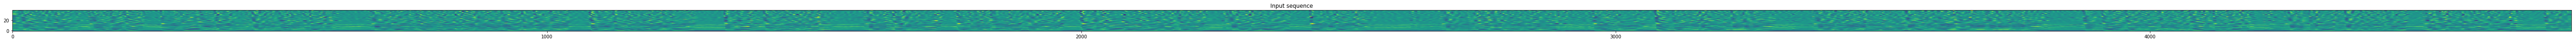

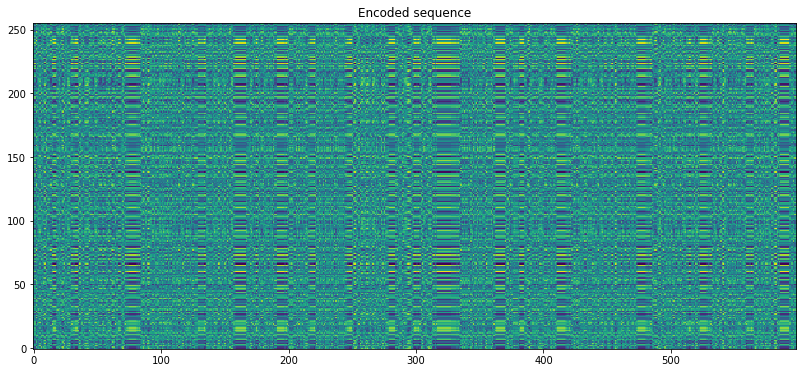

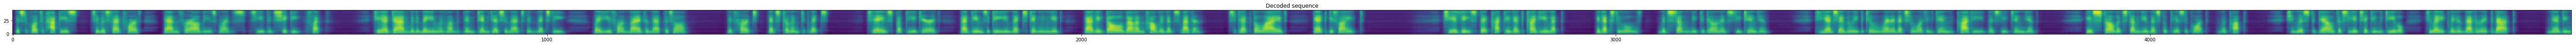

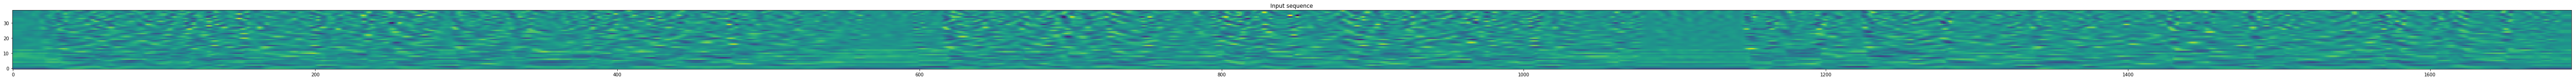

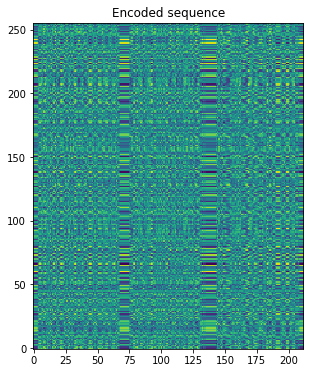

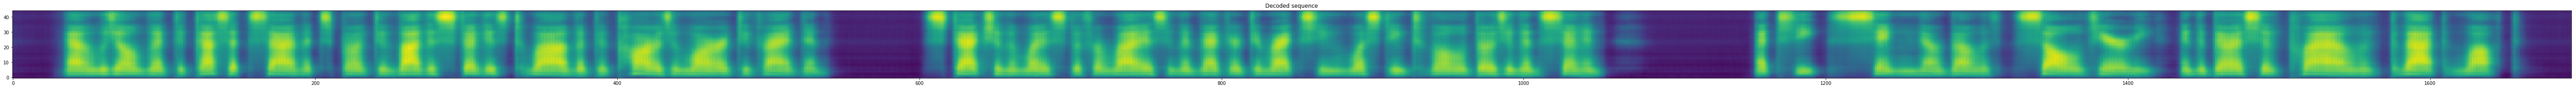

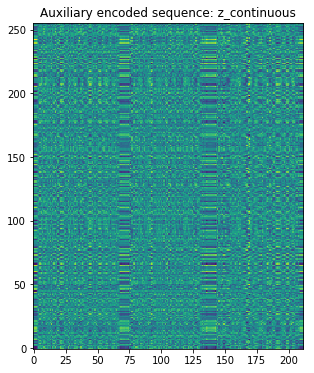

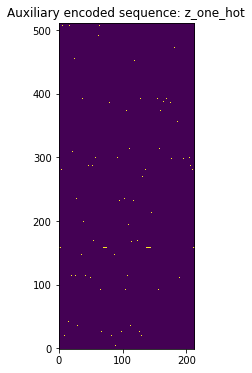

In [92]:
# COMPRESS AND RECONSTRUCT DATA WITH TRAINED MODEL
# ------------------------------------------------
test_feed = {
    tf.keras.backend.learning_phase(): 0  #, tau: [tau_min]
}

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

embed_final_epoch = True
embed_speaker = "V002"

target_speaker_id = speaker_to_id[embed_speaker]  #  "V001" or "V002" for target speakers
embed_dir = "speaker_{}{}".format(
    "none" if embed_speaker is None else embed_speaker,
    "_final_epoch" if embed_final_epoch else "")

embed_and_save(
    input_sets[0], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=None,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "train", embed_dir),
    batch_size=5, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

ex_batch = embed_and_save(
    input_sets[1], model_file, encoder_input, target_lengths, 
    bottleneck_output, model_output, aux_encoding_dict=auxillary_outputs,
    speaker_id=speaker_id, output_dir=os.path.join(model_dir, "test", embed_dir),
    batch_size=10, shuffle=False, config=config, additional_feed=test_feed,
    target_speaker_id=target_speaker_id)

In [131]:
# TRAIN MODEL
# -----------
train_feed = {
    tf.keras.backend.learning_phase(): 1
}

validation_feed = {
    tf.keras.backend.learning_phase(): 0
}

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # allocate only as much GPU memory as required by the session

record_dict = training.train_fixed_epochs(
    # Training params
    n_epochs, optimiser, loss_terms, train_iterator,  
    [encoder_input, decoder_target, speaker_id, target_lengths],
    # Validation params
    loss_terms, val_iterator, save_best_val_model_fn=model_file,
    # Additional params
    additional_train_feed=train_feed, additional_validation_feed=validation_feed,
    config=config, save_model_fn=model_file_final,
    # Continue training previous model
    load_model_fn=None, epoch_offset=0)

2019-03-14 09:23:51.251128
Epoch 0:
92.680 sec, train loss: [9.4805609e+04 2.6606216e+03 2.5629395e+04 1.4079386e+01 5.1258776e-02], val loss: [3.0816961e+04 8.1692365e+02 9.5769463e+03 1.4142325e+01 1.9153891e-02] *
Epoch 1:
91.469 sec, train loss: [9.6051465e+03 2.0439117e+02 4.2909731e+03 2.0530571e+01 8.5819457e-03], val loss: [1.6189348e+04 3.2096713e+02 7.8442031e+03 1.6986748e+01 1.5688406e-02] *
Epoch 2:
91.590 sec, train loss: [6.9289912e+03 1.1970196e+02 3.8167373e+03 2.5682096e+01 7.6334719e-03], val loss: [1.2112766e+04 1.8290540e+02 7.3572266e+03 2.1897482e+01 1.4714454e-02] *
Epoch 3:
91.488 sec, train loss: [5.8208496e+03 8.7209297e+01 3.5534062e+03 3.2643066e+01 7.1068150e-03], val loss: [1.1108069e+04 1.2722593e+02 7.8001934e+03 2.7540649e+01 1.5600387e-02]
Epoch 4:
91.128 sec, train loss: [5.1071299e+03 6.9343857e+01 3.3041877e+03 3.8718586e+01 6.6083767e-03], val loss: [9.9687891e+03 9.5002602e+01 7.4987212e+03 3.3143673e+01 1.4997444e-02]
Epoch 5:
91.267 sec, train 

Epoch 44:
90.795 sec, train loss: [2.8522478e+03 3.0812294e+01 2.0511284e+03 1.0485207e+02 4.1022543e-03], val loss: [7.3589253e+03 4.4827236e+01 6.1934165e+03 8.5464394e+01 1.2386833e-02] *
Epoch 45:
90.808 sec, train loss: [2.8452119e+03 3.0717751e+01 2.0465500e+03 1.0553736e+02 4.0931008e-03], val loss: [8.0504937e+03 5.0664093e+01 6.7332266e+03 8.4825638e+01 1.3466452e-02]
Epoch 46:
90.761 sec, train loss: [2.8113831e+03 3.0315397e+01 2.0231840e+03 1.0640721e+02 4.0463670e-03], val loss: [7.8277222e+03 4.6779797e+01 6.6114478e+03 8.7800415e+01 1.3222896e-02]
Epoch 47:
91.441 sec, train loss: [2.78453052e+03 2.99072876e+01 2.00694031e+03 1.07282326e+02
 4.01388295e-03], val loss: [8.1368931e+03 4.4144489e+01 6.9891362e+03 8.6839172e+01 1.3978273e-02]
Epoch 48:
90.834 sec, train loss: [2.7716685e+03 2.9595621e+01 2.0021819e+03 1.0849984e+02 4.0043644e-03], val loss: [7.5633022e+03 4.3865841e+01 6.4227896e+03 8.7395996e+01 1.2845580e-02]
Epoch 49:
90.866 sec, train loss: [2.7601123e+0

KeyboardInterrupt: 